In [1]:
import matplotlib.pylab as plt
import numba

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [70]:
# %load ../Code/Fits.py
import Estimation as st
from Histogram import Histogram as hist
from PDF import PDF
from Utils import IsotopeDic, PartDic
from scipy.stats import poisson
import matplotlib.pylab as plt
import scipy.optimize as sop
import numpy as np
from scipy.special import gammaln
from copy import copy

def generalLogPoisson(x,mu):
    try:
        return (-mu+x*np.log(mu+0.00001)-gammaln(x+1))
    except:
        print(mu)

class Fit():
    '''
    Class meant to perform the fit
    '''
    def __init__(self, E, spectrum, PDFs):
        '''
        E: x range (np array)
        spectrum: experimental points
        PDF: list of spectra PDFs
        nevs: normalizations for the spectra (they are the
            initial values for the fit)
        '''
        self.E = E[:]
        self.spectrum = spectrum.hist[:]
        self.PDFs = copy(PDFs)
        self.PDF_Val = np.array([np.array(pdfi.pdf(E)) for pdfi in self.PDFs])
        
    def LogLikelihood(self, nevs):
        '''
        function meant to compute the LogLikelihood
        '''
        nevs = nevs.reshape(len(nevs),1)
        ypdf = np.sum(nevs*self.PDF_Val,axis=0)
        ydat = self.spectrum
        lm = (np.array(generalLogPoisson(ydat,ypdf))).sum()
        return -lm

        
        
    def FitLLM(self,nevs,bounds=None, **kwargs):
        nevs = nevs.reshape(len(np.array(nevs)),1)
        fit = self.LogLikelihood
        if bounds==None:
            bounds = [[0,None] ] *(len(nevs))
        #res = sop.minimize(fit,nevs,method='L-BFGS-B',bounds = bounds,**kwargs)
        res = sop.minimize(fit,nevs,method='Nelder-Mead',**kwargs)
        ypdf = np.sum(nevs*self.PDF_Val,axis=0)
        ydat = self.spectrum
        chi2 = -1
        if (res.success):
            chi2 = np.sum((ypdf-ydat)**2/((ydat+0.0001)*(len(ypdf)-len(nevs))))
        res.chi2 = chi2
        return res
    
    def FitLLMScan(self,nevs, fixn, npoint=100, **kwargs):
        nevs = nevs.reshape(len(np.array(nevs)),1)
        aux = nevs[fixn]
        aux_evs = np.delete(nevs,fixn)
        fun_aux = self.FitLLM(nevs, **kwargs).fun
        res_list = []
        for aux_s in np.linspace(0,2*aux,npoint):
            fit = lambda x_nevs: self.LogLikelihood(np.insert(x_nevs,fixn,aux_s))
            #res = sop.minimize(fit,nevs,method='L-BFGS-B',bounds = bounds,**kwargs)
            res = sop.minimize(fit,aux_evs,method='Nelder-Mead',**kwargs)
            res_list.append(res.fun-fun_aux)
            #print(aux_s,res)
            if not(res.success):
                print('error')
            
        return np.linspace(0,2*aux,npoint),res_list
    def GetError(self, nevs, **kwargs):
        error = []
        nevs = nevs.reshape(len(np.array(nevs)),1)
        for fixn in range(1):#len(nevs)):
        
            aux = nevs[fixn]
            aux_evs = np.delete(nevs,fixn)
            fun_aux = self.FitLLM(nevs, **kwargs).fun
            res_list = []
           
            fit = lambda aux_s:  (lambda x_nevs: self.LogLikelihood(np.insert(aux_evs,fixn,aux_s)) )
            #res = sop.minimize(fit,nevs,method='L-BFGS-B',bounds = bounds,**kwargs)
            res = lambda aux_s: sop.minimize(fit(aux_s),aux_evs,method='Nelder-Mead',**kwargs)
            print(sop.brenth(res,0,aux))
            #res_list.append(res.fun-fun_aux)
            #print(aux_s,res)
           # if not(res.success):
            #    print('error')

        
        
    def GetSpectra(self,E,*nevs):
        ypdf = np.array([sum([n*pdfi.pdf(Ei) for pdfi,n in zip(self.PDFs,nevs)]) for Ei in self.E])
        #print ypdf
        return ypdf

    def FitLeastSQ(self,nevs,**kwargs):
        nevs = np.array(nevs)
        fit = self.GetSpectra
        res = sop.curve_fit(fit,self.E,self.spectrum, nevs)
        return res


In [4]:
f = tb.open_file("../Data/data_spectrum.h5", "r")

In [5]:
f

File(filename=../Data/data_spectrum.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Bi (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/Co (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/E (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/K (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/Tl (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/bb2n (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  b

In [6]:
minE,maxE,nbin = 0.6,3.,125
E = f.root.E[:]
Co = f.root.Co[:]
K = f.root.K[:]
Tl = f.root.Tl[:]
Bi = f.root.Bi[:]
bb2n = f.root.bb2n[:]
testnn = f.root.testnn[:]
total = f.root.total[:]

In [7]:
h_Co = hist([],nbin,minE,maxE)
h_Co.hist = Co
h_Co.bins = E
h_K = hist([], nbin,minE,maxE)
h_K.hist = K
h_K.bins = E
h_Tl = hist([],nbin,minE,maxE)
h_Tl.hist = Tl
h_Tl.bins = E
h_Bi = hist([],nbin,minE,maxE)
h_Bi.hist = Bi
h_Bi.bins = E
h_bb2n = hist([],nbin,minE,maxE)
h_bb2n.hist = bb2n
h_bb2n.bins = E
h_testnn = hist(testnn,nbin,minE,maxE)
h_testnn.hist = testnn
h_testnn.bins = E
h_total = hist(total,nbin,minE,maxE)
h_total.hist = total
h_total.bins = E

In [8]:
interpol = 'cubic'
pdf_Co = PDF(h_Co,interpolation=interpol)
pdf_K = PDF(h_K,interpolation=interpol)
pdf_Tl = PDF(h_Tl,interpolation=interpol)
pdf_Bi = PDF(h_Bi,interpolation=interpol)
pdf_bb2n = PDF(h_bb2n,interpolation=interpol)
pdf_testnn = PDF(h_testnn,interpolation=interpol)
pdf_total = PDF(h_total,interpolation=interpol)

In [9]:
pdflis = [pdf_Co,pdf_K,pdf_Tl,pdf_Bi,pdf_bb2n]
nevslist = np.array([150000,80000,15000,40000,20000])/8.

In [67]:
fit = Fit(E,h_total,pdflis)

In [29]:
%time res_ll = fit.FitLLM(nevslist,tol=1e-10,options={"maxiter":100000,'ftol':1e-20})
#"gtol":1e-12, ,'maxls':50

CPU times: user 58.2 ms, sys: 46 µs, total: 58.2 ms
Wall time: 56.1 ms


In [30]:
res_ll

          chi2: 1.7545517115556524
 final_simplex: (array([[ 18395.0973629 ,  10041.57996118,   1992.7751794 ,   4838.85734773,
          1384.68928794],
       [ 18395.0973629 ,  10041.57996118,   1992.7751794 ,   4838.85734773,
          1384.68928794],
       [ 18395.0973629 ,  10041.57996118,   1992.7751794 ,   4838.85734773,
          1384.68928794],
       [ 18395.0973629 ,  10041.57996118,   1992.7751794 ,   4838.85734773,
          1384.68928794],
       [ 18395.0973629 ,  10041.57996118,   1992.7751794 ,   4838.85734773,
          1384.68928794],
       [ 18395.0973629 ,  10041.57996118,   1992.7751794 ,   4838.85734773,
          1384.68928794]]), array([ 715.13490661,  715.13490661,  715.13490661,  715.13490661,
        715.13490661,  715.13490661]))
           fun: 715.134906606767
       message: 'Optimization terminated successfully.'
          nfev: 560
           nit: 276
        status: 0
       success: True
             x: array([ 18395.0973629 ,  10041.57996118,   1

In [31]:
nevslist

array([ 18750.,  10000.,   1875.,   5000.,   2500.])

In [32]:
%time res_ls = fit.FitLeastSQ(nevslist,tol=1e-12,options={"maxiter":1000})

CPU times: user 1.07 s, sys: 57.3 ms, total: 1.13 s
Wall time: 1.06 s


In [33]:
for i in range(len(res_ls[0])):
    print(res_ls[0][i],' +- ', (res_ls[1][i,i])**0.5)

18967.8383795  +-  297.667231852
10149.6005837  +-  248.442467245
2634.76085786  +-  397.014502889
4478.6278918  +-  312.113365883
540.682346863  +-  478.157932923


# Errors

/home/brais/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in log


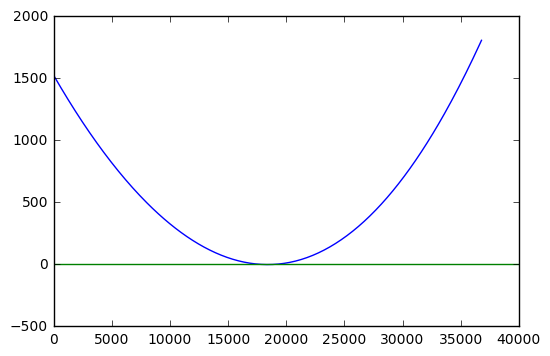

In [68]:
scan = fit.FitLLMScan(np. array([ 18395.02927031,  10041.54032921,   1992.53167288,   4839.01680656,1384.77826122]),0,300)
plt.plot(scan[0],np.array(scan[1])-1)
plt.plot([0,40000],[0,0])

(-0.5, 5)

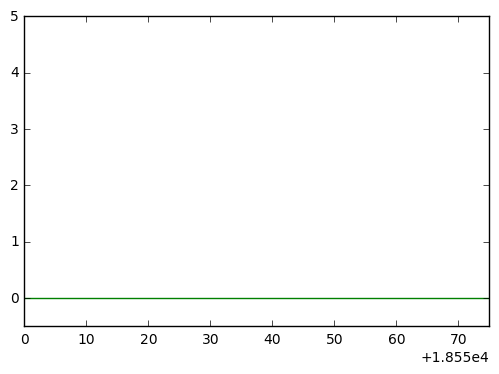

In [69]:
plt.plot(scan[0],np.array(scan[1])-1)
plt.plot([0,40000],[0,0])
plt.xlim(18550,18625)
plt.ylim(-.5,5)

In [47]:
fit.GetError(np.array([ 18395.02927031,  10041.54032921,   1992.53167288,   4839.01680656,1384.77826122]))

SystemError: PyEval_EvalFrameEx returned a result with an error set

In [ ]:
N = 100
nx = np.linspace(0,result[i]*2,N)
LL = []
chi = []
for ni in nx:
    res = fit.FitLLMScan(nevslist,ni,tol=1e-8,options={"maxiter":1000})
    LL.append(res.fun)
    chi.append(res.chi2)
    print(ni,'\n',res,'\n \n')

In [ ]:
plt.plot(nx,LL)
#plt.plot(nx,chi)


In [ ]:
N = 50
for i in range(5):
    nevs = np.copy(result)
    x = np.linspace(0,result[i]*3,N)
    y = np.zeros([N,1])
    for event in range(len(x)):
        nevs[i] = x[event]
        y[event] = fit.LogLikelihood(nevs)
    plt.plot(x,y-357.46490713137422-2)
    plt.plot(result[i],fit.LogLikelihood(result)-357.46490713137422-2,'o')
plt.plot([0,60000],[0,0])

In [ ]:
plt.plot(x,y-357.46490713137422-0.5)
plt.plot(result[i],fit.LogLikelihood(result)-357.46490713137422-0.5,'o')
plt.plot([x[0],x[-1]],[0,0])
plt.xlim(1225,1226)
plt.ylim(-0.005151,0.0051)
#for i in 

In [ ]:
x = np.linspace(0,result[i]*3,1000)

In [ ]:
res

In [ ]:
357.46490713125877 - 362.333


In [ ]:
1384.7787-1225

In [ ]:
testnn.sum()

In [ ]:
bb2n.sum()

In [ ]:
(1376.0-1384.7787)/159.7787

In [ ]:
1383.24

# Plot

In [ ]:
result = np.array([18395.02975447, 10041.5398816, 1992.53178756, 4839.01641257, 1384.7787113])

In [ ]:
interpol = 'nearest'
pdf_CoP = PDF(h_Co,factor=result[0],interpolation=interpol)
pdf_KP = PDF(h_K,factor=result[1],interpolation=interpol)
pdf_TlP = PDF(h_Tl,factor=result[2],interpolation=interpol)
pdf_BiP = PDF(h_Bi,factor=result[3],interpolation=interpol)
pdf_bb2nP = PDF(h_bb2n,factor=result[4],interpolation=interpol)



In [ ]:
Ep = np.linspace(0.6,2.8,1000)
aux =(E>0.6)&(E<2.8)
Ea = E[aux]
totala = total[aux]
testnna = testnn[aux]
y_CoP = pdf_CoP.pdf(Ep)
y_KP = pdf_KP.pdf(Ep)
y_TlP = pdf_TlP.pdf(Ep)
y_BiP = pdf_BiP.pdf(Ep)
y_bb2nP = pdf_bb2nP.pdf(Ep)
fittotal = y_CoP+y_KP+y_TlP+y_BiP+y_bb2nP
y_CoP[0]=0.00001
y_CoP[-1]=0.00001
y_KP[0]=0.00001
y_KP[-1]=0.00001
y_BiP[0]=0.00001
y_BiP[-1]=0.00001
y_TlP[0]=0.00001
y_TlP[-1]=0.00001


In [ ]:
alfa= 0.2
plt.semilogy()
plt.ylim(0.5,3e3)
plt.errorbar(Ea,totala,yerr=np.sqrt(totala),marker='.',elinewidth=1,
             linewidth=0,label='data',color='black')
plt.errorbar(Ea,testnna,yerr=np.sqrt(testnna),marker='.',elinewidth=1,
             linewidth=0,label='bb2n_data',color='m')
plt.plot(Ep,fittotal,label='fit')
plt.plot(Ep,y_bb2nP,label='bb2n_fit')
plt.fill_between(Ep,0,y_CoP,label='Co_fit',alpha=alfa,color='r')
plt.fill_between(Ep,0,y_KP,label='K_fit',alpha=alfa,color='g')
plt.fill_between(Ep,0,y_TlP,label='Tl_fit',alpha=alfa,color='y')
plt.fill_between(Ep,0,y_BiP,label='Bi_fit',alpha=alfa,color='b')
#plt.plot(E)
plt.gcf().set_size_inches(12,9)
plt.legend().get_frame().set_facecolor('0.95')
plt.xlabel('Energy (MeV)',fontsize=16)
plt.ylabel('Entries',fontsize=18)
plt.savefig('fitspectrum.pdf')

In [ ]:
alfa= 0.2
plt.semilogy()
plt.ylim(0.5,3e3)
plt.errorbar(Ea,totala,yerr=np.sqrt(totala),marker='.',elinewidth=1,
             linewidth=0,label='data',color='black')
plt.errorbar(Ea,testnna,yerr=np.sqrt(testnna),marker='.',elinewidth=1,
             linewidth=0,label='bb2n_data',color='m')
plt.plot(Ep,fittotal,label='fit')
plt.plot(Ep,y_bb2nP,label='bb2n_fit')
plt.fill_between(Ep,0,y_CoP,label='Co_fit',alpha=alfa,color='r')
plt.fill_between(Ep,0,y_KP,label='K_fit',alpha=alfa,color='g')
plt.fill_between(Ep,0,y_TlP,label='Tl_fit',alpha=alfa,color='y')
plt.fill_between(Ep,0,y_BiP,label='Bi_fit',alpha=alfa,color='b')
#plt.plot(E)

plt.gcf().set_size_inches(12,9)
plt.legend().get_frame().set_facecolor('0.95')
plt.xlabel('Energy (MeV)',fontsize=16)
plt.ylabel('Entries',fontsize=18)
plt.savefig('fitspectrum.pdf')

In [ ]:
alfa= 0.2
#plt.semilogy()
plt.ylim(0.5,3e3)
plt.errorbar(Ea,totala,yerr=np.sqrt(totala),marker='.',elinewidth=1,
             linewidth=0,label='data',color='black')
plt.errorbar(Ea,testnna,yerr=np.sqrt(testnna),marker='.',elinewidth=1,
             linewidth=0,label='bb2n_data',color='m')
plt.plot(Ep,fittotal,label='fit')
plt.plot(Ep,y_bb2nP,label='bb2n_fit')
plt.fill_between(Ep,0,y_CoP,label='Co_fit',alpha=alfa,color='r')
plt.fill_between(Ep,0,y_KP,label='K_fit',alpha=alfa,color='g')
plt.fill_between(Ep,0,y_TlP,label='Tl_fit',alpha=alfa,color='y')
plt.fill_between(Ep,0,y_BiP,label='Bi_fit',alpha=alfa,color='b')
#plt.plot(E)
plt.gcf().set_size_inches(12,9)
plt.legend().get_frame().set_facecolor('0.95')
plt.xlabel('Energy (MeV)',fontsize=16)
plt.ylabel('Entries',fontsize=18)
plt.savefig('fitspectrum.pdf')

In [ ]:
total.sum()

In [ ]:
result.sum()